# Agentic RAG System
This notebook implements a fully agentic Retrieval-Augmented Generation (RAG) workflow for answering complex questions grounded in documents such as NVIDIA's 10-K filings. It combines LangChain’s composable chains and retrievers with LangSmith’s tracing and evaluation capabilities to build, inspect, and optimize the system end to end.

Overview of Features:
- **Question Rewriting**: Reformulates user questions into more retrieval-effective queries using a language model.
- **Context Retrieval**: Retrieves passages from both detailed and summary vector stores to ensure semantic coverage.
- **Context Filtering**: Applies an LLM-based step to eliminate irrelevant content from retrieved documents.
- **Answer Generation with Chain-of-Thought**: Uses structured reasoning to produce grounded, explainable answers from context.
- **Evaluation and Quality Control**:
    - Detects hallucinated answers via factual grounding checks.
    - Determines whether the question can be fully answered by the retrieved context.
    - Grades the relevance of retrieved documents to the question.
    - Optionally compares the generated answer to reference answers using LangSmith’s evaluation suite.

This notebook provides a flexible and testable RAG architecture suitable for high-stakes domains such as finance, legal, and research where traceability and factual consistency are essential.



In [1]:
import os

# Set environment variables
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "Agentic RAG"


# Verify that the environment variables are set
print("Environment Variables Set:")
print(f'LANGSMITH_TRACING: {os.getenv("LANGSMITH_TRACING")}')
print(f'LANGSMITH_ENDPOINT: {os.getenv("LANGSMITH_ENDPOINT")}')
print(f'LANGSMITH_PROJECT: {os.getenv("LANGSMITH_PROJECT")}')

Environment Variables Set:
LANGSMITH_TRACING: true
LANGSMITH_ENDPOINT: https://api.smith.langchain.com
LANGSMITH_PROJECT: RAG_Agent_Partial_2


In [2]:
from langchain_openai import ChatOpenAI 
from langchain.document_loaders import  PyPDFLoader
from langchain.vectorstores import  FAISS
from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings 
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from langsmith import traceable
import langgraph

from langgraph.graph import END, StateGraph


/Users/user/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3548: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ········


## LLM and Embedding Model

In [4]:
# Load LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=8000,
)


## Loading Data/Vector Stores

In [5]:
from langchain_openai import OpenAIEmbeddings

summary_vectorstore = FAISS.load_local("summary_vectorstore_new", OpenAIEmbeddings(model="text-embedding-3-large"), allow_dangerous_deserialization=True)
detailed_vectorstore = FAISS.load_local("nvidia_chunk_semantic",  OpenAIEmbeddings(model="text-embedding-3-large"), allow_dangerous_deserialization=True)

## Retrieve Context from Detailed and Summary Stores

In [6]:
@traceable
def retrieve_context_per_question(state):
    """
    Retrieves relevant context for a given question from detailed and summary vector stores.
    """
    question = state["question"]

    print("Retrieving relevant detailed chunks...")
    detailed_docs = detailed_vectorstore.as_retriever(search_kwargs={"k": 5}).get_relevant_documents(question)

    detailed_context = " ".join(doc.page_content for doc in detailed_docs)

    print("Retrieving relevant page summaries...")
    summary_docs = summary_vectorstore.as_retriever(search_kwargs={"k": 3}).get_relevant_documents(question)

    summary_context = " ".join(
        f"{doc.page_content} (Page {doc.metadata.get('page', 'unknown')})"
        for doc in summary_docs
    )

    # Combine both contexts (detailed and summary)
    all_contexts = detailed_context + "\n\n" + summary_context
    all_contexts = escape_quotes(all_contexts)

    return {"context": all_contexts, "question": question}

## Filter Irrelevant Content from Retrieved Chunks

In [7]:
keep_only_relevant_content_prompt_template = """you receive a query: {query} and retrieved documents: {retrieved_documents} from a
 vector store.
 You need to filter out all the non relevant information that don't supply important information regarding the {query}.
 your goal is just to filter out the non relevant information.
 you can remove parts of sentences that are not relevant to the query or remove whole sentences that are not relevant to the query.
 DO NOT ADD ANY NEW INFORMATION THAT IS NOT IN THE RETRIEVED DOCUMENTS.
 output the filtered relevant content.
"""


class KeepRelevantContent(BaseModel):
    relevant_content: str = Field(description="The relevant content from the retrieved documents that is relevant to the query.")

keep_only_relevant_content_prompt = PromptTemplate(
    template=keep_only_relevant_content_prompt_template,
    input_variables=["query", "retrieved_documents"],
)


keep_only_relevant_content_llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini", max_tokens=2000)
keep_only_relevant_content_chain = keep_only_relevant_content_prompt | keep_only_relevant_content_llm.with_structured_output(KeepRelevantContent)

/Users/user/anaconda3/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1360: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


In [8]:
def escape_quotes(text):
  """Escapes both single and double quotes in a string.

  Args:
    text: The string to escape.

  Returns:
    The string with single and double quotes escaped.
  """
  return text.replace('"', '\\"').replace("'", "\\'")

## Extract Only Query-Relevant Content

In [9]:
@traceable
def keep_only_relevant_content(state):
    """
    Keeps only the relevant content from the retrieved documents that is relevant to the query.

    Args:
        question: The query question.
        context: The retrieved documents.
        chain: The LLMChain instance.

    Returns:
        The relevant content from the retrieved documents that is relevant to the query.
    """
    question = state["question"]
    context = state["context"]

    input_data = {
    "query": question,
    "retrieved_documents": context
}
    print("keeping only the relevant content...")
    print("--------------------")
    output = keep_only_relevant_content_chain.invoke(input_data)
    relevant_content = output.relevant_content
    relevant_content = "".join(relevant_content)
    relevant_content = escape_quotes(relevant_content)

    return {"relevant_context": relevant_content, "context": context, "question": question}

## Rewrite Question for Better Retrieval

In [10]:
from langchain_core.output_parsers import JsonOutputParser

class RewriteQuestion(BaseModel):
    """
    Output schema for the rewritten question.
    """
    rewritten_question: str = Field(description="The improved question optimized for vectorstore retrieval.")
    explanation: str = Field(description="The explanation of the rewritten question.")

rewrite_question_string_parser = JsonOutputParser(pydantic_object=RewriteQuestion)


rewrite_llm = llm
rewrite_prompt_template = """You are a question re-writer that converts an input question to a better version optimized for vectorstore retrieval.
 Analyze the input question {question} and try to reason about the underlying semantic intent / meaning.
 {format_instructions}
 """

rewrite_prompt = PromptTemplate(
    template=rewrite_prompt_template,
    input_variables=["question"],
    partial_variables={"format_instructions": rewrite_question_string_parser.get_format_instructions()},
)

question_rewriter = rewrite_prompt | rewrite_llm | rewrite_question_string_parser  # Combine prompt, LLM, and parser

@traceable
def rewrite_question(state):
    """Rewrites the given question using the LLM.

    Args:
        state: A dictionary containing the question to rewrite.
    """
    question = state["question"]
    print("Rewriting the question...")
    result = question_rewriter.invoke({"question": question})
    new_question = result["rewritten_question"]
    print(new_question)
    return {"question": new_question}

## Experiment - Everything Up Until Now

Experiment how it's working up until now.

In [11]:
@traceable
def process_query(question):
    state = {"question": question}

    # 1. Rewrite question to improve retrieval quality
    state.update(rewrite_question(state))

    # 2. Retrieve both summary and detailed context
    state.update(retrieve_context_per_question(state))

    # 3. Filter to keep only relevant content
    state.update(keep_only_relevant_content(state))

    # 4. Return final result
    return state["relevant_context"]

In [12]:
if __name__ == "__main__":
    query = "Who is the CEO of NVIDIA?"
    final_context = process_query(query)

    print("\n=== Final Filtered Relevant Context ===")
    print(final_context)

Rewriting the question...
Who currently holds the position of CEO at NVIDIA?
Retrieving relevant detailed chunks...


/var/folders/8_/66zkglc51d973l0mk64lcrkc0000gn/T/ipykernel_67536/2765202389.py:9: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  detailed_docs = detailed_vectorstore.as_retriever(search_kwargs={"k": 5}).get_relevant_documents(question)


Retrieving relevant page summaries...
keeping only the relevant content...
--------------------

=== Final Filtered Relevant Context ===
As of February 16, 2024, Jen-Hsun Huang is the President and Chief Executive Officer of NVIDIA. He co-founded NVIDIA in 1993 and has served as CEO since the company\'s inception.


## Answer with Chain-of-Thought Reasoning from Context

In [13]:
class QuestionAnswerFromContext(BaseModel):
    answer_based_on_content: str = Field(description="generates an answer to a query based on a given context.")

question_answer_from_context_llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini", max_tokens=2000)

question_answer_cot_prompt_template = """ 
Examples of Chain-of-Thought Reasoning

Example 1
Context: Mary is taller than Jane. Jane is shorter than Tom. Tom is the same height as David.
Question: Who is the tallest person?
Reasoning Chain:
The context tells us Mary is taller than Jane.
It also says Jane is shorter than Tom.
And Tom is the same height as David.
So the order from tallest to shortest is: Mary, Tom/David, Jane.
Therefore, Mary must be the tallest person.

Example 2
Context: NVIDIA reported record revenue in 2024, driven by strong demand for AI chips and data center products. However, the company also cited risks related to supply chain disruptions and increasing regulatory scrutiny.
Question: What factors contributed to NVIDIA’s record revenue in 2024?
Reasoning Chain:
The context states that NVIDIA reported record revenue in 2024.
It attributes this growth to strong demand for AI chips and data center products.
Therefore, the main factors contributing to NVIDIA’s record revenue are the increasing demand for AI hardware and growth in the data center segment.

Instructions:
For the question below, provide your answer by first showing your step-by-step reasoning process, breaking down the problem into a chain of thought before arriving at the final answer, just like in the previous examples.

Context:
{context}

Question:
{question}
"""


question_answer_from_context_cot_prompt = PromptTemplate(
    template=question_answer_cot_prompt_template,
    input_variables=["context", "question"],
)
question_answer_from_context_cot_chain = question_answer_from_context_cot_prompt | question_answer_from_context_llm.with_structured_output(QuestionAnswerFromContext)

@traceable
def answer_question_from_context(state):
    """
    Answers a question from a given context.

    Args:
        question: The query question.
        context: The context to answer the question from.
        chain: The LLMChain instance.

    Returns:
        The answer to the question from the context.
    """
    question = state["question"]
    context = state["aggregated_context"] if "aggregated_context" in state else state["context"]

    input_data = {
    "question": question,
    "context": context
}
    print("Answering the question from the retrieved context...")

    output = question_answer_from_context_cot_chain.invoke(input_data)
    answer = output.answer_based_on_content
    print(f'answer before checking hallucination: {answer}')
    return {"answer": answer, "context": context, "question": question}

/Users/user/anaconda3/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1360: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


## Create graph edges

In [14]:
is_relevant_content_prompt_template = """you receive a query: {query} and a context: {context} retrieved from a vector store. 
You need to determine if the document is relevant to the query. 

{format_instructions}"""

class Relevance(BaseModel):
    is_relevant: bool = Field(description="Whether the document is relevant to the query.")
    explanation: str = Field(description="An explanation of why the document is relevant or not.")

is_relevant_json_parser = JsonOutputParser(pydantic_object=Relevance)
# is_relevant_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
is_relevant_llm = llm



is_relevant_content_prompt = PromptTemplate(
    template=is_relevant_content_prompt_template,
    input_variables=["query", "context"],
    partial_variables={"format_instructions": is_relevant_json_parser.get_format_instructions()},
)
is_relevant_content_chain = is_relevant_content_prompt | is_relevant_llm | is_relevant_json_parser

@traceable
def is_relevant_content(state):
    """
    Determines if the document is relevant to the query.

    Args:
        question: The query question.
        context: The context to determine relevance.
    """

    question = state["question"]
    context = state["context"]

    input_data = {
    "query": question,
    "context": context
}

    # Invoke the chain to determine if the document is relevant
    output = is_relevant_content_chain.invoke(input_data)
    print("Determining if the document is relevant...")
    if output["is_relevant"] == True:
        print("The document is relevant.")
        return "relevant"
    else:
        print("The document is not relevant.")
        return "not relevant"

### LLM chain to check if an answer is a hallucination or grounded on facts

In [15]:
class is_grounded_on_facts(BaseModel):
    """
    Output schema for the rewritten question.
    """
    grounded_on_facts: bool = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

is_grounded_on_facts_llm = llm
is_grounded_on_facts_prompt_template = """You are a fact-checker that determines if the given answer {answer} is grounded in the given context {context}
you don't mind if it doesn't make sense, as long as it is grounded in the context.
output a json containing the answer to the question, and appart from the json format don't output any additional text.

 """
is_grounded_on_facts_prompt = PromptTemplate(
    template=is_grounded_on_facts_prompt_template,
    input_variables=["context", "answer"],
)
is_grounded_on_facts_chain = is_grounded_on_facts_prompt | is_grounded_on_facts_llm.with_structured_output(is_grounded_on_facts)

### LLM chain to determine if a question can be fully answered given a context

In [16]:
can_be_answered_prompt_template = """You receive a query: {question} and a context: {context}. 
You need to determine if the question can be fully answered based on the context.
{format_instructions}
"""
class QuestionAnswer(BaseModel):
    can_be_answered: bool = Field(description="binary result of whether the question can be fully answered or not")
    explanation: str = Field(description="An explanation of why the question can be fully answered or not.")

can_be_answered_json_parser = JsonOutputParser(pydantic_object=QuestionAnswer)

answer_question_prompt = PromptTemplate(
    template=can_be_answered_prompt_template,
    input_variables=["question","context"],
    partial_variables={"format_instructions": can_be_answered_json_parser.get_format_instructions()},
)

can_be_answered_llm = llm
can_be_answered_chain = answer_question_prompt | can_be_answered_llm | can_be_answered_json_parser

### Function to check both cases - hallucination and full answer

In [17]:
@traceable
def grade_generation_v_documents_and_question(state):
    """
    Grades the generation of the answer to the question based on the context, if it is grounded in the facts, and if the question can be fully answered

    Args:
        state: A dictionary containing the context, question, and answer.
    """
    
    print("Checking if the answer is grounded in the facts...")
    context = state["context"]
    answer = state["answer"]
    question = state["question"]
    
    result = is_grounded_on_facts_chain.invoke({"context": context, "answer": answer})
    grounded_on_facts = result.grounded_on_facts
    if not grounded_on_facts:
        print("The answer is hallucination.")
        return "hallucination"
    else:
        print("The answer is grounded in the facts.")

        input_data = {
            "question": question,
            "context": context
        }

        # Invoke the chain to determine if the question can be answered
        print("Determining if the question is fully answered...")
        output = can_be_answered_chain.invoke(input_data)
        can_be_answered = output["can_be_answered"]
        if can_be_answered == True:
            print("The question can be fully answered.")
            return "useful"
        else:
            print("The question cannot be fully answered.")
            return "not_useful"

In [18]:
init_state = {"question": "When did the CEO join NVIDIA?"}  # The question to answer
context_state = retrieve_context_per_question(init_state)  # Retrieve context for the question
relevant_content_state = keep_only_relevant_content(context_state)  # Keep only the relevant content
is_relevant_content_state = is_relevant_content(relevant_content_state) # Check if the content is relevant
answer_state = answer_question_from_context(relevant_content_state) # Answer the question from the context
final_answer = grade_generation_v_documents_and_question(answer_state) # Grade the answer
print(answer_state["answer"])

Retrieving relevant detailed chunks...
Retrieving relevant page summaries...
keeping only the relevant content...
--------------------
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
answer before checking hallucination: The context states that Jen-Hsun Huang co-founded NVIDIA in 1993 and has served as the President and Chief Executive Officer since the company's inception.
Checking if the answer is grounded in the facts...
The answer is grounded in the facts.
Determining if the question is fully answered...
The question can be fully answered.
The context states that Jen-Hsun Huang co-founded NVIDIA in 1993 and has served as the President and Chief Executive Officer since the company's inception.


## Build Qualitative Retrieval → Rewrite → Answer Graph Workflow

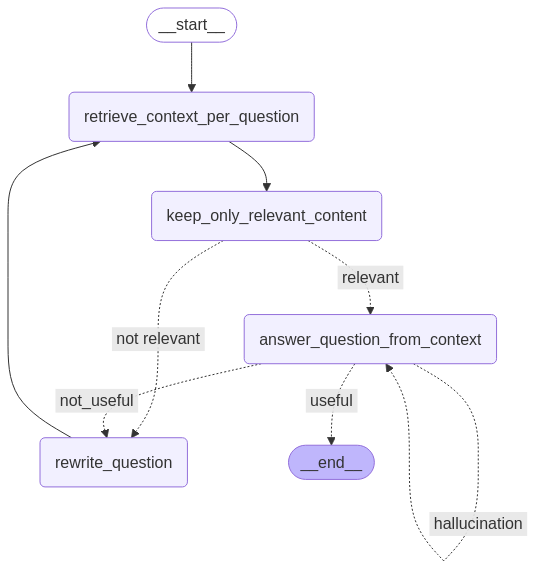

In [19]:
from typing_extensions import TypedDict
from IPython.display import display, Image

class QualitativeRetievalAnswerGraphState(TypedDict):

    question: str
    context: str
    answer: str

# Create the graph
qualitative_retrieval_answer_workflow = StateGraph(QualitativeRetievalAnswerGraphState)

# Define the nodes

# Add the nodes to the graph
qualitative_retrieval_answer_workflow.add_node("retrieve_context_per_question",retrieve_context_per_question)
qualitative_retrieval_answer_workflow.add_node("keep_only_relevant_content",keep_only_relevant_content)
qualitative_retrieval_answer_workflow.add_node("rewrite_question",rewrite_question)
qualitative_retrieval_answer_workflow.add_node("answer_question_from_context",answer_question_from_context)

# Build the graph
qualitative_retrieval_answer_workflow.set_entry_point("retrieve_context_per_question")
qualitative_retrieval_answer_workflow.add_edge("retrieve_context_per_question", "keep_only_relevant_content")
qualitative_retrieval_answer_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_relevant_content,
    {"relevant":"answer_question_from_context",
      "not relevant":"rewrite_question"},
    )
qualitative_retrieval_answer_workflow.add_edge("rewrite_question", "retrieve_context_per_question")
qualitative_retrieval_answer_workflow.add_conditional_edges(
"answer_question_from_context",
grade_generation_v_documents_and_question,
{"hallucination":"answer_question_from_context",
"not_useful":"rewrite_question",
"useful":END},
)

qualitative_retrieval_answer_retrival_app = qualitative_retrieval_answer_workflow.compile()

display(
    Image(
        qualitative_retrieval_answer_retrival_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [20]:
# Invoke the graph with your question
result = qualitative_retrieval_answer_retrival_app.invoke({
    "question": "What is the lifestory of NVIDIA’s CFO, was he/she already at the firm when the Arm Acquisition was terminated?",
    "context": "",  # Start with an empty context
    "answer": ""   # Start with an empty answer
})

# Print the final result
print("Final Answer:", result["answer"])

Retrieving relevant detailed chunks...
Retrieving relevant page summaries...
keeping only the relevant content...
--------------------
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
answer before checking hallucination: Colette M. Kress is the Chief Financial Officer (CFO) of NVIDIA. She joined NVIDIA in 2013 as Executive Vice President and Chief Financial Officer. Before joining NVIDIA, she served as Senior Vice President and Chief Financial Officer of the Business Technology and Operations Finance organization at Cisco Systems, Inc. since 2010. At Cisco, she was responsible for financial strategy, planning, reporting, and business development for all business segments. Prior to her time at Cisco, Kress held various positions at Microsoft from 1997 to 2010, including Chief Financial Officer of the Server and Tools division. 

Regarding the Arm Acquisition, the termination of the Share Purchase Agreement between

In [24]:
result["context"]

"Table of Contents\nOur support is enhanced during times of crisis, such as war or economic volatility, to take care of our existing team of world-class talent and their families. Diversity, Inclusion, and Belonging\nWe believe that diverse teams fuel innovation, and we are committed to creating an inclusive culture that supports all employees. When recruiting for new talent or developing our current employees, we strive to build a diverse talent pipeline that includes those underrepresented in thetechnology field, including women, Black/African American, and Hispanic/Latino candidates. To this end, we have been:\n• Partnering with institutions and professional organizations serving historically underrepresented communities;\n• Embedding dedicated recruiting teams to business areas to shepherd underrepresented candidates through the interview process and find internalopportunities;\n• Supporting the development of women employees through programs aimed at building a pipeline of future 

## RAG Evaluation Dataset

In [25]:
# Import the LangSmith client
from langsmith import Client

# Initialize the LangSmith client
ls_client = Client()

# Read an existing dataset by name
dataset_name = "RAG_Eval_QA"
dataset = ls_client.read_dataset(dataset_name=dataset_name)

# List examples in the dataset
examples = ls_client.list_examples(dataset_name=dataset_name)

# Iterate through examples
for example in examples:
    print(example.inputs)  # Print input data
    print(example.outputs)  # Print output data


{'question': "What was NVIDIA's revenue in 2024 and 2023? Which year saw higher revenues and by how much?"}
{'answer': "Revenue in 2024 was $60,922 million ($60.9 billion) , revenue in 2023 was $26,974 million ($27.0 billion). NVIDIA's revenue increased by $33,948 million (or $33.95 billion depending on the rounding) in 2024 compared to 2023."}
{'question': 'Between January 29, 2023, and January 28, 2024, NVIDIA’s total assets increased by approximately $24.5 billion. Based on the balance sheet, which two line items contributed the most to this increase, and what does this suggest about the company’s capital deployment focus?'}
{'answer': 'Between January 29, 2023, and January 28, 2024, NVIDIA’s total assets increased by approximately $24.5 billion, rising from $41.2 billion to $65.7 billion. Based on the balance sheet, the two line items that contributed the most to this increase were marketable securities, which increased from $9.9 billion to $18.7 billion, and cash and cash equivale

In [26]:
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.1,  # Slow down requests
    check_every_n_seconds=0.1,
    max_bucket_size=10
)

# Apply to your model

model = ChatOpenAI(model="gpt-4o", temperature=0, rate_limiter=rate_limiter)

/var/folders/8_/66zkglc51d973l0mk64lcrkc0000gn/T/ipykernel_9582/2168577922.py:3: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


## RAG Evaluators

### Type 1: Reference Answer

First, lets consider the case in which we want to compare our RAG chain answer to a reference answer.

#### Eval flow

We simply use an LLM-as-judge with an easily customized grader prompt: 

In [27]:
# RAG chain
def predict_rag_answer(example: dict):
    """Use this for answer evaluation"""
    response = qualitative_retrieval_answer_retrival_app.invoke({
    "question": example["question"],
    "context": "",  # Start with an empty context
    "answer": ""   # Start with an empty answer
})
    return {"answer": response["answer"]}

In [28]:
def predict_rag_answer_with_context(example: dict):
    """Use this for evaluation of retrieved documents and hallucinations"""
    response = qualitative_retrieval_answer_retrival_app.invoke({
    "question": example["question"],
    "context": "",  # Start with an empty context
    "answer": ""   # Start with an empty answer
})
    return {"answer": response["answer"], "contexts": response["context"]}

In [29]:
# set the LANGSMITH_API_KEY environment variable (create key in settings)
from langchain import hub
grade_prompt_answer_accuracy = hub.pull("answer_vs_reference")

In [30]:
def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """
    
    # Get summary
    input_question = example.inputs["question"]
    reference = example.outputs["answer"]
    prediction = run.outputs["answer"]

    # LLM grader
    # llm = ChatOpenAI(model="gpt-4o", temperature=0)
    
    llm = model
 
    # Structured prompt
    
    answer_grader = grade_prompt_answer_accuracy | llm

    # Get score
    score = answer_grader.invoke({"question": input_question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_score", "score": score}

In [31]:
from langsmith.evaluation import evaluate

dataset_name = "RAG_test_NVIDIA"
experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    experiment_prefix="RAG_Agent_Partial",
    metadata={"variant": "NVIDIA context, gpt-4o-mini"},
)

View the evaluation results for experiment: 'RAG_Agent_Partial-96009770' at:
https://smith.langchain.com/o/f09c54fc-44b8-4ffe-9055-bc40601f9137/datasets/7fad5e82-7b2d-438e-90e6-1e232f388896/compare?selectedSessions=6344fcae-8eb3-47c8-8f6b-4ca096144976




0it [00:00, ?it/s]

Retrieving relevant detailed chunks...Retrieving relevant detailed chunks...

Retrieving relevant detailed chunks...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
keeping only the relevant content...
--------------------
keeping only the relevant content...
--------------------
keeping only the relevant content...
--------------------
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
answer before checking hallucination: The context provides information about the executive officers of NVIDIA, specifically mentioning Jen-Hsun Huang as the President and Chief Executive Officer. Therefore, the CEO of NVIDIA is J

### Type 2: Answer Hallucination

#### Eval flow

We simply use an LLM-as-judge with an easily customized grader prompt: 

https://smith.langchain.com/hub/langchain-ai/rag-answer-hallucination

In [31]:
# set the LANGSMITH_API_KEY environment variable (create key in settings)
from langchain import hub
grade_prompt_hallucinations = hub.pull("hallucination")

In [32]:
# Prompt 

# grade_prompt_hallucinations = hub.pull("langchain-ai/rag-answer-hallucination")

def answer_hallucination_evaluator(run, example) -> dict:
    """
    A simple evaluator for generation hallucination
    """
    
    # RAG inputs
    input_question = example.inputs["question"]
    contexts = run.outputs["contexts"]
        
    # RAG answer 
    prediction = run.outputs["answer"]

    # LLM grader
    # llm = ChatOpenAI(model="gpt-4o", temperature=0)
    
    llm = model

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}

In [37]:
dataset_name = "RAG_test_NVIDIA"
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[answer_hallucination_evaluator],
    experiment_prefix="RAG_Agent_Partial",
    metadata={"variant": "NVIDIA context, gpt-4o-mini"},
)

View the evaluation results for experiment: 'RAG_Agent_Partial-a686938f' at:
https://smith.langchain.com/o/f09c54fc-44b8-4ffe-9055-bc40601f9137/datasets/7fad5e82-7b2d-438e-90e6-1e232f388896/compare?selectedSessions=8c49114a-7eb1-4cb3-bd03-b75af894e70b




0it [00:00, ?it/s]

Retrieving relevant detailed chunks...Retrieving relevant detailed chunks...

Retrieving relevant detailed chunks...
Retrieving relevant page summaries...Retrieving relevant page summaries...

Retrieving relevant page summaries...
keeping only the relevant content...
--------------------
keeping only the relevant content...
--------------------
keeping only the relevant content...
--------------------
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
answer before checking hallucination: The context provides information about the executive officers of NVIDIA, specifically mentioning Jen-Hsun Huang as the President and Chief Executive Officer. Therefore, the CEO of NVIDIA is Jen-Hsun Huang.
Checking if the answer is grounded in the facts...
The answer is grounded in the facts.
Determining if the 

### Type 3: Document Relevance to Question

#### Eval flow

We simply use an LLM-as-judge with an easily customized grader prompt: 

https://smith.langchain.com/hub/langchain-ai/rag-document-relevance

In [33]:
# set the LANGSMITH_API_KEY environment variable (create key in settings)
from langchain import hub
grade_prompt_doc_relevance = hub.pull("doc_question_relevance")

In [34]:
# Grade prompt 
# grade_prompt_doc_relevance = hub.pull("langchain-ai/rag-document-relevance")

def docs_relevance_evaluator(run, example) -> dict:
    """
    A simple evaluator for document relevance
    """
    
    # RAG inputs
    input_question = example.inputs["question"]
    contexts = run.outputs["contexts"]
        
    # RAG answer 
    prediction = run.outputs["answer"]

    # LLM grader
    # llm = ChatOpenAI(model="gpt-4o", temperature=0)
    
    llm = model

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":input_question,
                                  "documents":contexts})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

In [41]:
dataset_name = "RAG_test_NVIDIA"
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[docs_relevance_evaluator],
    experiment_prefix="RAG_Agent_Partial",
    metadata={"variant": "NVIDIA context, gpt-4ov-mini"},
)

View the evaluation results for experiment: 'RAG_Agent_Partial-b4540290' at:
https://smith.langchain.com/o/f09c54fc-44b8-4ffe-9055-bc40601f9137/datasets/7fad5e82-7b2d-438e-90e6-1e232f388896/compare?selectedSessions=33551c38-1b06-4add-8a04-8a6b1c8072eb




0it [00:00, ?it/s]

Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
keeping only the relevant content...keeping only the relevant content...
--------------------

--------------------
keeping only the relevant content...
--------------------
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
answer before checking hallucination: The context provides information about the executive officers of NVIDIA, specifically mentioning Jen-Hsun Huang as the President and Chief Executive Officer. Therefore, the CEO of NVIDIA is Jen-Hsun Huang.
Checking if the answer is grounded in the facts...
answer before checking hallucination: NVIDIA's revenue f

# Complete Evaluation

In [35]:
from langsmith.evaluation import evaluate

dataset_name = "RAG_Eval_QA"
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[answer_evaluator, answer_hallucination_evaluator, docs_relevance_evaluator],
    experiment_prefix="RAG_Agent_Partial_Semantic",
    metadata={"variant": "NVIDIA context, gpt-4o-mini"},
)

View the evaluation results for experiment: 'RAG_Agent_Partial_Semantic-66bb815b' at:
https://smith.langchain.com/o/f09c54fc-44b8-4ffe-9055-bc40601f9137/datasets/176f75c1-604f-435b-b0c7-9eda1bdef775/compare?selectedSessions=16bbb805-166f-4197-9ab2-0620e82c79da




0it [00:00, ?it/s]

Retrieving relevant detailed chunks...Retrieving relevant detailed chunks...

Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant detailed chunks...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
keeping only the relevant content...
--------------------
keeping only the relevant content...
--------------------
keeping only the relevant content...

keeping only the relevant content...
--------------------
The answer is grounded in the facts.
Determining if the question is fully answered...
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
answer before checking hallucination: To analyze the modest increase in NVIDIA's cash balance at year-end 2024 despite a substantial increase in operating cash flow, we can break down the situation as follows:

1. **Operating Cash Flow Increase**: NVIDIA's cash flow from operating activities surged to $28.1 billion in fiscal year 2024, a significant increase from $5.6 billion in 2023. This increase was primarily driven by a rise in net income, which jumped from $4.4 billion to $29.8 billion, along with adjustments for stock-based compensation.

2. **Investing Activities**: Despite the strong operating cas

The answer is grounded in the facts.
Determining if the question is fully answered...
The question can be fully answered.
Retrieving relevant detailed chunks...
The answer is grounded in the facts.
Determining if the question is fully answered...
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
Retrieving relevant page summaries...
The answer is grounded in the facts.
Determining if the question is fully answered...
answer before checking hallucination: To analyze NVIDIA's performance across different regions in the global market, we can break down the revenue figures provided in the context:

1. **United States**: In the fiscal year ending January 28, 2024, NVIDIA generated $26,966 million in revenue from the United States, which is a significant increase from $8,292 million in 2023 and $4,349 million in 2022. This growth is attributed to higher demand in the U.S.-based Compute & Networking segment.

2. **Taiwan*

The question can be fully answered.
answer before checking hallucination: The key competitors identified in NVIDIA's 10-K filing include:

1. **Advanced Micro Devices, Inc. (AMD)** - Competes in the GPU and CPU markets, offering discrete and integrated GPUs, custom chips, and accelerated computing solutions.

2. **Huawei Technologies Co. Ltd. (Huawei)** - Competes in the GPU, CPU, and AI computing sectors, providing hardware and software solutions.

3. **Intel Corporation (Intel)** - Competes in the CPU market and is involved in AI computing, offering a range of hardware and software solutions.

4. **Alibaba Group** - A large cloud services company that designs its own hardware and software incorporating accelerated or AI computing functionality.

5. **Alphabet Inc. (Google)** - Another cloud services giant with internal teams focused on hardware and software for AI applications.

6. **Amazon, Inc. (Amazon)** - Competes through its cloud services and designs hardware and software for A

# Complete Evaluation 

In [42]:
dataset_name = "RAG_test_NVIDIA"
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[answer_evaluator, answer_hallucination_evaluator, docs_relevance_evaluator],
    experiment_prefix="RAG_Agent_Partial",
    metadata={"variant": "NVIDIA context, gpt-4o-mini"},
)

View the evaluation results for experiment: 'RAG_Agent_Partial-691a3556' at:
https://smith.langchain.com/o/f09c54fc-44b8-4ffe-9055-bc40601f9137/datasets/7fad5e82-7b2d-438e-90e6-1e232f388896/compare?selectedSessions=0590cede-11a5-4a92-82a4-ebe7d5396ae8




0it [00:00, ?it/s]

Retrieving relevant detailed chunks...Retrieving relevant detailed chunks...

Retrieving relevant detailed chunks...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
Retrieving relevant page summaries...
keeping only the relevant content...
--------------------
keeping only the relevant content...
--------------------
keeping only the relevant content...
--------------------
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
answer before checking hallucination: NVIDIA's revenue for fiscal year 2024 was $60.9 billion, while for fiscal year 2023 it was $26.97 billion. The year 2024 saw higher revenues, with an increase of $33.93 billion.
Checking if the answer is grounded in the facts...
The answer is grounded in the facts.
Determining if the question is fully answered..